# CS-6580 Assignment 5 - Transformers (Solutions)

**Dylan Zwick - Instructor**

*Weber State University*

<center>
    <div>
        <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihZ2YbUE_QnIwPLRb0cbQrp1tv3XS5NeYJoAi6YrdvLrwziUfZbbf1uQR5Ek_zYNL7OFXXUMmZTN776hhXU4dkiMgJel=s1600" width = 450/>
    </div>
</center>

Transformers are a [big deal](https://youtu.be/9uw3F6rndnA?feature=shared). For this assignment you will get your hands dirty implementing the [transformer architecture](https://arxiv.org/abs/1706.03762) we've discussed in class. I know it was a lot and might have seemed confusing, but don't worry - we'll walk through it.

This assignment is based upon the final programming assignment from Andrew Ng's [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning) course on Corsera, although it is significantly modified. Specifically, we'll be using the unit tests written for that assignment. You'll need to download them, so let's do that now. I've made them available on my Google Drive, so you'll just download them from there.

First, you'll need to make sure you have the [gdown](https://pypi.org/project/gdown/) library. You probably do, but just in case you can run the code below. Installing it if you've already got it won't cause any problems - your environment will just check and see you've already got it, which will mean it does nothing. It just might take a few second to do the check.

In [1]:
!pip install gdown

Alright, now that you've got gdown, let's import it and use it to get the *public_tests.py* file that contains our unit tests.

In [2]:
import gdown

In [3]:
url = 'https://drive.google.com/uc?id=11IxRzXkTLoJKuqgnC7swCKRfjyRB7Xk6'
output = 'public_tests.py'
gdown.download(url,output)

from public_tests import *

Downloading...
From (original): https://drive.google.com/uc?id=11IxRzXkTLoJKuqgnC7swCKRfjyRB7Xk6
From (redirected): https://drive.google.com/uc?id=11IxRzXkTLoJKuqgnC7swCKRfjyRB7Xk6&confirm=t&uuid=1cd38cd6-a8de-4ffd-a39e-8e5a7bcb4ae4
To: /content/public_tests.py
100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 15.4k/15.4k [00:00<00:00, 12.0MB/s]


Alright - you should now have a *public_tests.py* file in your working directory, and the unit tests from that file should now be imported and ready to run from your environment. Sweet.

Now that we've imported the files specific to this assignment, let's import the libraries and methods we'll need for this assignment.

In [4]:
#Our data science friends we just can't live without
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Our deep learning friends we've gotten to know a bit
import tensorflow as tf
from tensorflow import keras

#We'll also grab a couple others that will be useful to us
import time

We'll also want to import some methods from Keras that will be useful to us as we code our transformer - and that we don't want to create from scratch.

In [6]:
from keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization

In [7]:
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
from transformers import TFDistilBertForTokenClassification

## Part 1 - Positional Encoding

The first thing we'll do is write some function to handle positional encoding. This was covered in class, but there are also a number of videos on youtube that go over it. One example is [this one](https://youtu.be/zxQyTK8quyY?feature=shared&t=439). A good article on the reason positional encoding is done how it's done is [here](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In many sequence to sequence tasks, the relative order of the data is important to its meaning. This is certainly the case with text and translation. Order information is inherent to the structure of an RNN, and in its operation the data is given to the model in sequence.  However, for a Transformer network using multi-head attention, the data is given to the model all at once. While this can significantly reduce training time, there is no information about the relative order. This is where positional encoding comes in - you can specifically encode the positions of your inputs and pass them into the network. The values of these encodings come from these sine and cosine formulas:
    
$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2}$$

* $d$ is the dimension of the word embedding (the number of components in the vector representation of a word)
* $pos$ is the position of the word.
* $k$ refers to each of the different dimensions in the positional encodings, with $i$ equal to $k$ $//$ $2$ (this in integer division, so for example $6 // 2 = 7 // 2 = 3$).

You can think of the positional encodings broadly as a feature that contains the information about the relative positions of words. The sum of the positional encoding and word embedding is ultimately what is fed into the model. The values of the sine and cosine equations are small enough (between -1 and 1) that when you add the positional encoding to a word embedding, the word embedding is not significantly distorted, and is instead enriched with positional information. Using a combination of these two equations helps your Transformer network attend to the relative positions of your input data. Why the $10000$ in the denominator? It's really just a hyperparameter that seems to work well.

### Sine and Cosine Angles

Notice that even though the sine and cosine positional encoding equations take in different arguments (`2i` versus `2i+1`, or even versus odd numbers) the inner terms for both equations are the same:

$$
\theta(pos, i, d) = \frac{pos}{10000^{\frac{2i}{d}}} \tag{3}
$$

Consider the inner term as you calculate the positional encoding for a word in a sequence.<br>

$$
PE_{(pos, 0)}= sin\left(\frac{pos}{{10000}^{\frac{0}{d}}}\right),
$$

since solving `2i = 0` gives `i = 0` <br>

$$
PE_{(pos, 1)}= cos\left(\frac{pos}{{10000}^{\frac{0}{d}}}\right),
$$

since solving `2i + 1 = 1` gives `i = 0`

The angle is the same for both! The angles for $PE_{(pos, 2)}$ and $PE_{(pos, 3)}$ are the same as well, since for both, `i = 1` and therefore the inner term is $\left(\frac{pos}{{10000}^{\frac{2}{d}}}\right)$. This relationship holds true for all paired sine and cosine curves.

### Exercise 1 - get_angles

For your first exercise, you'll implement the function `get_angles()` to calculate the possible angles for the sine and cosine positional encodings. In the code you'll want to replace anywhere you see *None* with appropriate code, unless the comments specifically tell you to leave a specific *None* alone. That's basically what you do for all the exercises in this assignment.

**Hints**

- If `k = [0, 1, 2, 3, 4, 5]`, then, `i` must be `i = [0, 0, 1, 1, 2, 2]`
- `i = k//2`
- Keep track of the shape of your vectors.
- [List comprehensions](https://www.w3schools.com/python/python_lists_comprehension.asp) could be a smooth way to do this.

In [8]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding

    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size

    Returns:
        angles -- (pos, d) numpy array
    """

    # START CODE HERE
    # Get i from dimension span k
    i = [x//2 for x in k[0]]
    # Calculate the angles using pos, i and d
    angles = np.asarray([[y[0]/(10000**(2*x/d)) for x in i] for y in pos])
    # END CODE HERE

    return angles

OK. Now we're going to run our unit test to check if the code above passes. This unit test is one of the ones we imported at the top of this notebook. If it doesn't pass, there's an issue with your code, and you should fix it. If it does pass the unit test will output "All tests passed".

Also, we'll generate an example of an angle array that can be produced with this function.

In [9]:
# UNIT TEST
get_angles_test(get_angles)

# Example
position = 4
d_model = 8
pos_m = np.arange(position)[:, np.newaxis]
dims = np.arange(d_model)[np.newaxis, :]
get_angles(pos_m, dims, d_model)

All tests passed


array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e+00, 1.e+00, 1.e-01, 1.e-01, 1.e-02, 1.e-02, 1.e-03, 1.e-03],
       [2.e+00, 2.e+00, 2.e-01, 2.e-01, 2.e-02, 2.e-02, 2.e-03, 2.e-03],
       [3.e+00, 3.e+00, 3.e-01, 3.e-01, 3.e-02, 3.e-02, 3.e-03, 3.e-03]])

### Sine and Cosine Encodings

Now you can use the angles you computed to calculate the sine and cosine positional encodings.

$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$

### Exercise 2 - positional_encoding

Implement the function `positional_encoding()` to calculate the sine and cosine  positional encodings

**Reminder:** Use the sine equation when $i$ is an even number and the cosine equation when $i$ is an odd number.

#### Additional Hints
* You may find
[np.newaxis](https://numpy.org/doc/stable/user/basics.indexing.html#dimensional-indexing-tools) useful depending on the implementation you choose.

In [10]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings

    Arguments:
        positions (int) -- Maximum number of positions to be encoded
        d (int) -- Encoding size

    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # START CODE HERE
    # initialize a matrix angle_rads of all the angles
    angle_rads = get_angles([[x] for x in range(positions)],
                            [[x for x in range(d)]],
                            d)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:,0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:,1::2])
    # END CODE HERE

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [11]:
# UNIT TEST
positional_encoding_test(positional_encoding, get_angles)

All tests passed


If your output was "All tests passed" then good job! The Coursera assignment has the following visualization of the positional encodings. You may find it insightful. I (Dylan) must admit I did not, but I've included it in case you're interested.

(1, 50, 512)


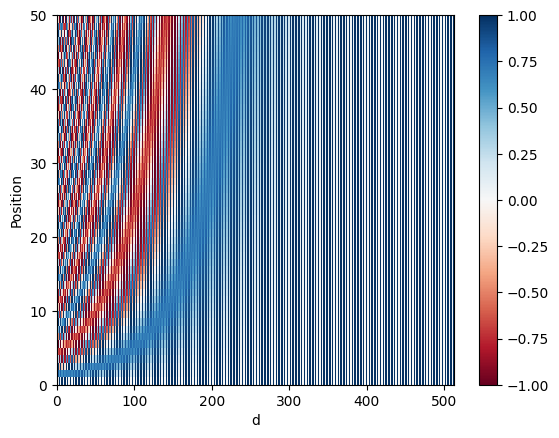

In [12]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Part 2 - Masking

Now let's look into how we handle masking. You can relax a bit for this section, as the coding is all handled for you. But, please read through it and make sure you understand it, both because doing so is important if you want to understand transformers, and because it might be useful later in the assignment.

There are two types of masks that are useful when building your Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in your input sentence.

### Padding Mask

Often your input sequence will exceed the maximum length of a sequence your network can process. Let's say the maximum length of your model is five (in practice hopefully it's much larger than THAT, but this is just an example), and it is given the following sequences:

    [["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"],
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

which might get vectorized (using [label encoding](https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/)) as:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]
    
When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model. Doing this, our sequence would turn into:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]
    
Sequences longer than the maximum length of five are truncated, and zeros are added to the truncated sequence to achieve uniform length. Similarly, for sequences shorter than the maximum length, zeros are added for padding. However, these zeros will affect the softmax calculation. With softmax, you're taking the exponential of each of the terms, and $e^{0}$ is $1$! This is when a padding mask comes in handy. What we want to do is make the numbers we want to ignore $-\infty$, and if we can't do that a very negative number like $-1e9$ wil do. This is implemented for you below. ðŸ˜‡ Just make sure you go through the code so you understand how it works.

After applying this masking, the padded input sequence `[87, 600, 0, 0, 0]` would change to `[87, 600, -1e9, -1e9, -1e9]`, so that when you take the softmax, the original zeros go to $0$ in the softmax.

**Note:** The [MultiheadAttention](https://keras.io/api/layers/attention_layers/multi_head_attention/) layer implemented in Keras uses this masking logic.

In [13]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells

    Arguments:
        decoder_token_ids -- (n, m) matrix

    Returns:
        mask -- (n, 1, m) binary tensor
    """
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    # this will allow for broadcasting later when comparing sequences
    return seq[:, tf.newaxis, :]

This code takes in an array of token IDs, and returns an array of indices for whether the token ID is non-zero. For example:

In [14]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[1. 1. 0. 0. 1.]]

 [[1. 1. 1. 0. 0.]]

 [[0. 0. 0. 1. 1.]]], shape=(3, 1, 5), dtype=float32)


If we multiply (1 - mask) by -1e9 and add it to the sample input sequences, the zeros are essentially set to negative infinity. Notice the difference when taking the softmax of the original sequence and the masked sequence:

In [15]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + (1 - create_padding_mask(x)) * -1.0e9))

tf.Tensor(
[[7.2876644e-01 2.6809821e-01 6.6454901e-04 6.6454901e-04 1.8064314e-03]
 [8.4437378e-02 2.2952460e-01 6.2391251e-01 3.1062774e-02 3.1062774e-02]
 [4.8541026e-03 4.8541026e-03 4.8541026e-03 2.6502505e-01 7.2041273e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[7.2973627e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00 1.8088354e-03]
  [2.4472848e-01 6.6524094e-01 0.0000000e+00 0.0000000e+00 9.0030573e-02]
  [6.6483542e-03 6.6483542e-03 0.0000000e+00 0.0000000e+00 9.8670328e-01]]

 [[7.3057157e-01 2.6876226e-01 6.6619506e-04 0.0000000e+00 0.0000000e+00]
  [9.0030573e-02 2.4472848e-01 6.6524094e-01 0.0000000e+00 0.0000000e+00]
  [3.3333331e-01 3.3333331e-01 3.3333331e-01 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105860e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 4.9999997e-01 4.9999997e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105860e-01]]], shape=(3, 3, 5), dtype=float32)


### Look-ahead Mask

The look-ahead mask follows similar intuition. In training, you will have access to the complete correct output of your training example. The look-ahead mask helps your model pretend that it correctly predicted a part of the output and see if, *without looking ahead*, it can correctly predict the next output.

For example, if the expected correct output is `[1, 2, 3]` and you wanted to see if given that the model correctly predicted the first value it could predict the second value, you would mask out the second and third values. So you would input the masked sequence `[1, -1e9, -1e9]` and see if it could generate `[1, 2, -1e9]`.

This mask is also implemented for you ðŸ˜‡ðŸ˜‡. Again, take a close look at the code so you understand how it works.

In [16]:
def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones

    Arguments:
        sequence_length -- matrix size

    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask

In [17]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

## Part 3 - Self-Attention

<center>
    <div>
        <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihYbPind89WT3zkPp4YhtteBz760p3OYxs32V2ZULwdxWEaoiH2iU5rgr8QYIyrJcdtEN02USwFn9UxbboGAdQoIw5FQ=s1600" width = 600/>
    </div>
</center>

You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to return rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

### Exercise 3 - scaled_dot_product_attention

Implement the function `scaled_dot_product_attention()` to create attention-based representations.

**Reminder**: The boolean mask parameter can be passed in as `none` or as either padding or look-ahead.
    
    Multiply (1. - mask) by -1e9 before applying the softmax.

**Additional Hints**
* You may find [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul) useful for matrix multiplication.
* The dimension of the keys is the number of rows in $K$, the matrix of keys.
* To take the square root of a value, you may need to convert in from an integer to a float. The function [tf.cast](https://www.tensorflow.org/api_docs/python/tf/cast) might be useful to you here.

In [18]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead)
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    # START CODE HERE

    matmul_qk = tf.matmul(q,tf.transpose(k))  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[0],dtype=tf.float32)
    scaled_attention_logits = matmul_qk/tf.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None: # Don't replace this None
        scaled_attention_logits += (1 - mask) * -1.0e9

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.keras.activations.softmax(scaled_attention_logits)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights,v)  # (..., seq_len_q, depth_v)

    # END CODE HERE

    return output, attention_weights

In [19]:
# UNIT TEST
scaled_dot_product_attention_test(scaled_dot_product_attention)

All tests passed


Did all your tests pass? If so, then great! Now let's build the encoder block.

## Part 4 - The Encoder

The Transformer Encoder layer pairs self-attention with a neural network to produce enhanced work encodings. In this section, you will implement the Encoder by pairing multi-head attention and a feed forward neural network.

<center>
    <div>
        <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihafp3hfQetahHU_fTtZoYZWEBE85_7Qi1uN9KNc8mt4uSk2dpBos8U9UNih6k7KFJZAh0MaFQIG64mA0GrA0frm7VnbQA=s1600" width = 350/>
        <caption><center><font color='purple'><b>Figure 2a: Transformer encoder layer</b></font></center></caption>
    </div>
</center>

Your input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.
   
* `MultiHeadAttention` you can think of as computing the self-attention several times to detect different features. For the `MultiHeadAttention` layer, you will use the [Keras implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). If you're curious about how to split the query matrix Q, key matrix K, and value matrix V into different heads, you can look through the implementation.
* The feed forward neural network contains two Dense layers we'll implement as the function `FullyConnected`. It will also use the [Sequential API](https://keras.io/api/models/sequential/) with two dense layers to built the feed forward neural network layers.

In [20]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, embedding_dim)
    ])

### Encoder Layer

Now you will pair multi-head attention and a feed forward neural network together in an encoder layer! You will also use residual connections and layer normalization because these seem to help.

### Exercise 4 - EncoderLayer

In this exercise, you will implement one encoder block (Figure 2) using the `call()` method. The function should perform the following steps:
1. You will pass the Q, V, K matrices and a boolean mask to a multi-head attention layer. Remember that to compute *self*-attention Q, V and K *should be the same*. Set the default values for `return_attention_scores` and `training`. You will also perform Dropout in this multi-head attention layer during training.
2. Now add a skip connection by adding your original input `x` and the output of the your multi-head attention layer.
3. After adding the skip connection, pass the output through the first normalization layer.
4. Finally, repeat steps 1-3 but with the feed forward neural network with a dropout layer instead of the multi-head attention layer.

**Additional Hints**
    
* The `__init__` method creates all the layers that will be accesed by the the `call` method. Wherever you want to use a layer defined inside  the `__init__`  method you will have to use the syntax `self.[insert layer name]`.
* You will find the documentation of [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) helpful. You might also find the section on this method from "Deep Learning with Python" helpful. *Note that if query, key and value are the same, then this function performs self-attention.*
* The call arguments for `self.mha` are (Where B is for batch_size, T is for target sequence shapes, and S is output_shape):
 - `query`: Query Tensor of shape (B, T, dim).
 - `value`: Value Tensor of shape (B, S, dim).
 - `key`: Optional key Tensor of shape (B, S, dim). If not given, will use value for both key and value, which is the most common case.
 - `attention_mask`: a boolean mask of shape (B, T, S), that prevents attention to certain positions. The boolean mask specifies which query elements can attend to which key elements, 1 indicates attention and 0 indicates no attention. Broadcasting can happen for the missing batch dimensions and the head dimension.
 - `return_attention_scores`: A boolean to indicate whether the output should be attention output if True, or (attention_output, attention_scores) if False. Defaults to False.
 - `training`: Python boolean indicating whether the layer should behave in training mode (adding dropout) or in inference mode (no dropout). Defaults to either using the training mode of the parent layer/model, or False (inference) if there is no parent layer. Take a look at [tf.keras.layers.Dropout](https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/layers/Dropout) for more details (Additional reading in [Keras FAQ](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute))

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network.
    This architecture includes a residual connection around each of the two
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer

        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not
                    treated as part of the input
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # START CODE HERE
        # calculate self-attention using mha(~1 line).
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        self_mha_output = self.mha(x,x,x, attention_mask = mask)  # Self attention (batch_size, input_seq_len, embedding_dim)

        # skip connection
        # apply layer normalization on sum of the input and the attention output to get the
        # output of the multi-head attention layer (~1 line)
        skip_x_attention = self.layernorm1(x + self_mha_output)  # (batch_size, input_seq_len, embedding_dim)

        # pass the output of the multi-head attention layer through a ffn (~1 line)
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, embedding_dim)

        # apply dropout layer to ffn output during training (~1 line)
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        # apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output to get the
        # output of the encoder layer (~1 line)
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)  # (batch_size, input_seq_len, embedding_dim)
        # END CODE HERE

        return encoder_layer_out

In [22]:
# UNIT TEST
EncoderLayer_test(EncoderLayer)

All tests passed


### Full Encoder

If you've made it this far and passed your tests, then you've now successfully implemented positional encoding, self-attention, and an encoder layer - give yourself a pat on the back. Now you're ready to build the full Transformer Encoder (Figure 2b), where you will embed your input and add the positional encodings you calculated. You will then input your encoded embeddings to a stack of Encoder layers.

<center>
  <div>
    <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihafp3hfQetahHU_fTtZoYZWEBE85_7Qi1uN9KNc8mt4uSk2dpBos8U9UNih6k7KFJZAh0MaFQIG64mA0GrA0frm7VnbQA=s1600" alt="Encoder" width="330"/>
    <caption><center><font color='purple'><b>Figure 2b: Transformer Encoder</b></font></center></caption>
  </div>
</center>

### Exercise 5 - Encoder

Complete the `Encoder()` function using the `call()` method to embed your input, add positional encoding, and implement multiple encoder layers.

In this exercise, you will initialize your Encoder with an Embedding layer, positional encoding, and multiple EncoderLayers. Your `call()` method will perform the following steps:
1. Pass your input through the Embedding layer.
2. Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type `tf.float32` before computing the square root.
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the `training` parameter to set the model training mode.
5. Pass the output of the dropout layer through the stack of encoding layers using a for loop.

In [23]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    encoder Layers

    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder

        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        seq_len = tf.shape(x)[1]

        # START CODE HERE
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.sqrt(tf.cast(self.embedding_dim,dtype=tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        # use `training=training`
        x = self.dropout(x,training=training)
        # Pass the output through the stack of encoding layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x,training,mask)
        # END CODE HERE

        return x  # (batch_size, input_seq_len, embedding_dim)

In [24]:
# UNIT TEST
Encoder_test(Encoder)

All tests passed


## Part 5 - Decoder

The Decoder layer takes the K and V matrices generated by the Encoder and computes the second multi-head attention layer with the Q matrix from the output (Figure 3a).

<center>
  <div>
    <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihZ9dj6hOfJ3IroGn4Ap8MaiBUalP3XDZRbMgsJbqa9yzuVgEf6PAwKExS81gFwyql1KDuC8lutDnJOsIN5z_-PdjFFYKw=s1600" alt="Encoder" width="250"/>
    <caption><center><font color='purple'><b>Figure 3a: Transformer Decoder layer</b></font></center></caption>
  </div>
</center>

### Decoder Layer
Again, you'll pair multi-head attention with a feed forward neural network, but this time you'll implement two multi-head attention layers. You will also use residual connections and layer normalization to help speed up training (Figure 3a).

### Exercise 6 - DecoderLayer
    
Implement `DecoderLayer()` using the `call()` method
    
1. Block 1 is a multi-head attention layer with a residual connection, and look-ahead mask. Like in the `EncoderLayer`, Dropout is defined within the multi-head attention layer.
2. Block 2 will take into account the output of the Encoder, so the multi-head attention layer will receive K and V from the encoder, and Q from the Block 1. You will then apply a normalization layer and a residual connection, just like you did before with the `EncoderLayer`.
3. Finally, Block 3 is a feed forward neural network with dropout and normalization layers and a residual connection.
    
**Additional Hints:**
* The first two blocks are fairly similar to the EncoderLayer except you will return `attention_scores` when computing self-attention

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks,
    one that takes the new input and uses self-attention, and the other
    one that combines it with the output of the encoder, followed by a
    fully connected block.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer

        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """

        # START CODE HERE
        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)

        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training (~1 line).
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, attention_mask = look_ahead_mask, return_attention_scores=True)  # (batch_size, target_seq_len, embedding_dim)

        # apply layer normalization (layernorm1) to the sum of the attention output and the input (~1 line)
        Q1 = self.layernorm1(x + mult_attn_out1)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output.
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2 (~1 line)
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output, attention_mask=padding_mask , return_attention_scores=True)  # (batch_size, target_seq_len, embedding_dim)

        # apply layer normalization (layernorm2) to the sum of the attention output and the output of the first block (~1 line)
        mult_attn_out2 = self.layernorm2(Q1 + mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)

        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)

        # apply a dropout layer to the ffn output
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3(mult_attn_out2 + ffn_output)  # (batch_size, target_seq_len, embedding_dim)
        # END CODE HERE

        return out3, attn_weights_block1, attn_weights_block2

In [26]:
# UNIT TEST
DecoderLayer_test(DecoderLayer, create_look_ahead_mask)

All tests passed


### Full Decoder
You're almost there! Time to use your Decoder layer to build a full Transformer Decoder (Figure 3b). You will embed your output and add positional encodings. You will then feed your encoded embeddings to a stack of Decoder layers.

<center>
  <div>
    <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihYYpVskdVvUrEZBJHhfmQwIGpnN0uou8uKARTwtH-XV0KSLoR09TA4AAZj9A7P0kG99_Pyx3zluBngmzYrJ351CBXixUg=s1600" alt="Encoder" width="300"/>
    <caption><center><font color='purple'><b>Figure 3b: Transformer Decoder</b></font></center></caption>
  </div>
</center>

### Exercise 7 - Decoder

Implement `Decoder()` using the `call()` method to embed your output, add positional encoding, and implement multiple decoder layers.

In this exercise, you will initialize your Decoder with an Embedding layer, positional encoding, and multiple DecoderLayers. Your `call()` method will perform the following steps:
1. Pass your generated output through the Embedding layer.
2. Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type `tf.float32` before computing the square root.
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the `training` parameter to set the model training mode.
5. Pass the output of the dropout layer through the stack of Decoding layers using a for loop.

In [27]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the target input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    decoder Layers

    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder

        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # START CODE HERE
        # create word embeddings
        x = self.embedding(x)  # (batch_size, target_seq_len, embedding_dim)

        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.sqrt(tf.cast(self.embedding_dim,dtype=tf.float32))

        # calculate positional encodings and add to word embedding
        x += self.pos_encoding[:, :seq_len, :]

        # apply a dropout layer to x
        # use `training=training`
        x = self.dropout(x, training=training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        # END CODE HERE

        # x.shape == (batch_size, target_seq_len, embedding_dim)
        return x, attention_weights

In [28]:
# UNIT TEST
Decoder_test(Decoder, create_look_ahead_mask, create_padding_mask)

All tests passed


## 6 - Transformer

This is the last exercise of the assignment. Congratulations! You've done all the hard work, now it's time to put it all together.  

<center>
  <div>
    <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihY073zPlP55IW_LIdi52N7hTJYne_Newk8-HHzpr7rvRx_U7XW0kCVwGcJyha8fHc60Kx0pWwvqSk4OrrmKZK2eVn9-8w=s1600" alt="Transformer" width="550"/>
    <caption><center><font color='purple'><b>Figure 4: Transformer</b></font></center></caption>
  </div>
</center>

The flow of data through the Transformer Architecture is as follows:
* First your input passes through an Encoder, which is just repeated Encoder layers that you implemented:
    - embedding and positional encoding of your input
    - multi-head attention on your input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers that you implemented:
    - embedding and positional encoding of the output
    - multi-head attention on your generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, one dense layer and a softmax are applied to generate prediction for the next output in your sequence.

### Exercise 8 - Transformer

Implement `Transformer()` using the `call()` method
1. Pass the input through the Encoder with the appropiate mask.
2. Pass the encoder output and the target through the Decoder with the appropiate mask.
3. Apply a linear transformation and a softmax to get a prediction.

In [29]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size,
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')

    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence -- Tensor of shape (batch_size, input_seq_len)
                              An array of the indexes of the words in the input sentence
            output_sentence -- Tensor of shape (batch_size, target_seq_len)
                              An array of the indexes of the words in the output sentence
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            dec_padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)

        """
        # START CODE HERE
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(input_sentence, training, enc_padding_mask)  # (batch_size, inp_seq_len, embedding_dim)

        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, embedding_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training, look_ahead_mask, dec_padding_mask)

        # pass decoder output through a linear layer and softmax (~2 lines)
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)
        # END CODE HERE

        return final_output, attention_weights

In [30]:
# UNIT TEST
Transformer_test(Transformer, create_look_ahead_mask, create_padding_mask)

tf.Tensor(
[[[0.04273601 0.02721556 0.0233324  0.03952922 0.02491077 0.01355808
   0.0224883  0.01778231 0.05234943 0.01228012 0.01728611 0.04094367
   0.0236425  0.01513873 0.03587775 0.03060059 0.03892459 0.05350363
   0.02690089 0.02714271 0.02005343 0.01879724 0.06774767 0.01690478
   0.02964078 0.02411472 0.0402912  0.01935925 0.03848543 0.0109739
   0.01991006 0.02355329 0.01657834 0.04273187 0.02471474]
  [0.02779409 0.03171974 0.02848468 0.02633933 0.01637403 0.02602075
   0.01175349 0.01049516 0.0216048  0.0301284  0.02471138 0.03332943
   0.06640176 0.04724112 0.02404947 0.03906032 0.0474421  0.01656918
   0.04491654 0.05136278 0.01502641 0.04051269 0.03414372 0.01169757
   0.02884136 0.02879692 0.01799022 0.01495265 0.0143846  0.0255447
   0.02490668 0.03082347 0.02165568 0.02013878 0.044786  ]
  [0.05026679 0.02342175 0.02425659 0.02277767 0.01298422 0.03511294
   0.04222918 0.01696841 0.03154733 0.01906234 0.02228023 0.06673498
   0.02072379 0.04418653 0.03745596 0.0331055

## Conclusion

When you've completed all the exercises and can pass all the unit tests, please upload the assignment (make sure you put your name at the top) to Canvas.

Thank you!